In [0]:
!pip install shap

In [0]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

In [0]:
!wget https://raw.githubusercontent.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/master/AI%20for%20Medical%20Prognosis/Week%202/util.py
!pip install lifelines

In [0]:
from util import load_data, cindex

In [18]:
!wget https://github.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/raw/master/AI%20for%20Medical%20Prognosis/Week%202/NHANESI_subset_X.csv
!wget https://github.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/raw/master/AI%20for%20Medical%20Prognosis/Week%202/NHANESI_subset_y.csv

--2020-06-15 01:05:40--  https://github.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/raw/master/AI%20for%20Medical%20Prognosis/Week%202/NHANESI_subset_y.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/master/AI%20for%20Medical%20Prognosis/Week%202/NHANESI_subset_y.csv [following]
--2020-06-15 01:05:40--  https://raw.githubusercontent.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/master/AI%20for%20Medical%20Prognosis/Week%202/NHANESI_subset_y.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [19]:
X_dev, X_test, y_dev, y_test = load_data(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

In [21]:
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


In [22]:
y_train.head(20)

1599    False
2794     True
1182    False
6915    False
500     False
1188     True
9739    False
3266    False
6681    False
8822    False
5856     True
3415    False
9366    False
7975    False
1397    False
6809    False
9461    False
9374    False
1170     True
158     False
Name: time, dtype: bool

In [23]:
i = 10
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    67.000000
Diastolic BP           94.000000
Poverty index         114.000000
Race                    1.000000
Red blood cells        43.800000
Sedimentation rate     12.000000
Serum Albumin           3.700000
Serum Cholesterol     178.000000
Serum Iron             73.000000
Serum Magnesium         1.850000
Serum Protein           7.000000
Sex                     1.000000
Systolic BP           140.000000
TIBC                  311.000000
TS                     23.500000
White blood cells       4.300000
BMI                    17.481227
Pulse pressure         46.000000
Name: 5856, dtype: float64

Died within 10 years? True


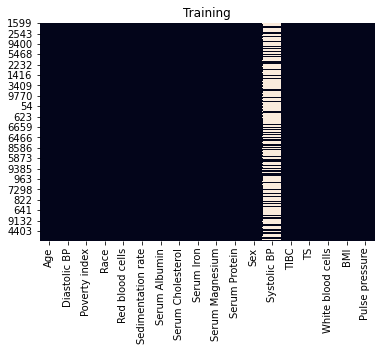

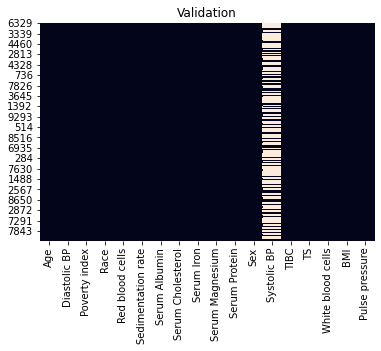

In [24]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

In [0]:
def fraction_rows_missing(df):
    return sum(df.isnull().any(axis=1)) / len(df)

In [26]:
df_test = pd.DataFrame({'a':[None, 1, 1, None], 'b':[1, None, 0, 1]})
print("Example dataframe:\n")
print(df_test)

print("\nComputed fraction missing: {}, expected: {}".format(fraction_rows_missing(df_test), 0.75))
print(f"Fraction of rows missing from X_train: {fraction_rows_missing(X_train):.3f}")
print(f"Fraction of rows missing from X_val: {fraction_rows_missing(X_val):.3f}")
print(f"Fraction of rows missing from X_test: {fraction_rows_missing(X_test):.3f}")

Example dataframe:

     a    b
0  NaN  1.0
1  1.0  NaN
2  1.0  0.0
3  NaN  1.0

Computed fraction missing: 0.75, expected: 0.75
Fraction of rows missing from X_train: 0.699
Fraction of rows missing from X_val: 0.704
Fraction of rows missing from X_test: 0.000


In [0]:
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]

X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

In [28]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

In [29]:
y_train_preds = dt.predict_log_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.5629321808510638


divide by zero encountered in log


In [0]:
# Experiment with different hyperparameters for the DecisionTreeClassifier
# until you get a c-index above 0.6 for the validation set
dt_hyperparams = {
    # set your own hyperparameters below, such as 'min_samples_split': 1
    'max_depth': 3,
}

In [31]:
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt_reg.predict_proba(X_train_dropped)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val_dropped)[:, 1]

print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 0.688738755448391
Val C-Index (expected > 0.6): 0.6302692819148936


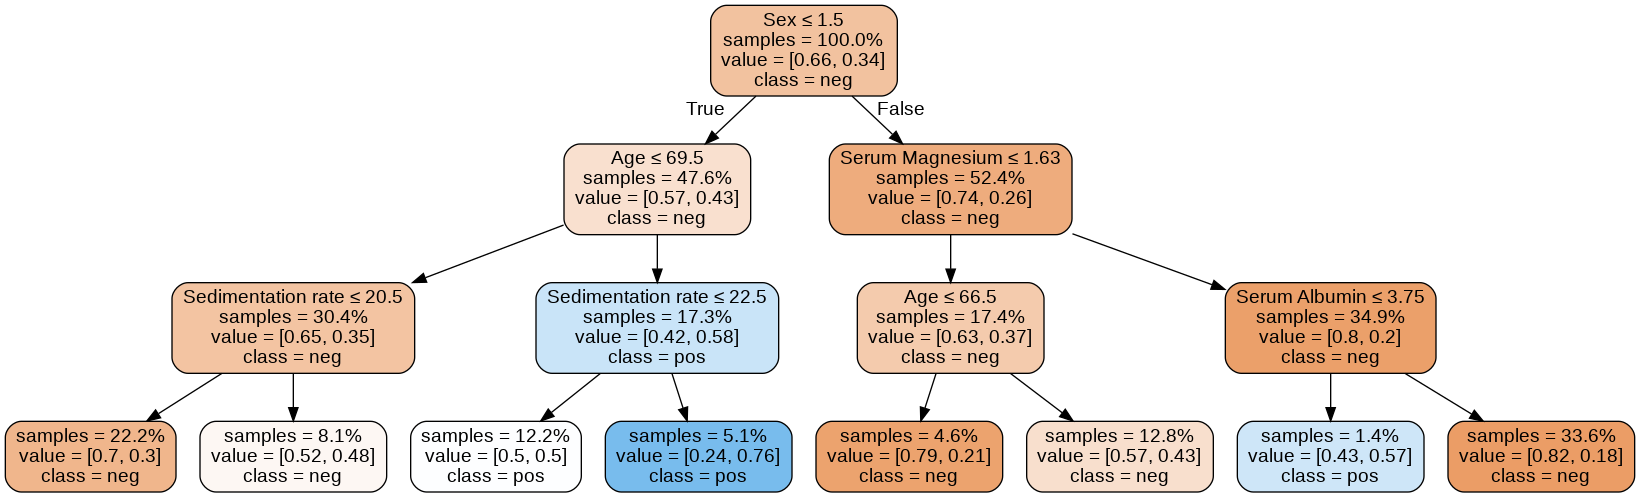

In [32]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train_dropped.columns, out_file=dot_data, filled=True,
                rounded=True, proportion=True, special_characters=True, impurity=False,
                class_names=['neg', 'pos'], precision=2)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [34]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [35]:
y_train_rf_preds = rf.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_rf_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6660488696808511


In [0]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    
    best_estimator = None
    best_hyperparams = {}

    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()

    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)

    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]

        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train_hp, y_train_hp)

        # get predictions on validation set
        preds = estimator.predict_proba(X_val_hp)

        # compute cindex for predictions
        estimator_score = cindex(y_val_hp, preds[:, 1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # if new high score, update high score, best estimator
        # and best params
        if estimator_score >= best_score:
            best_score = estimator_score
            best_estimator = estimator
            best_hyperparams = param_dict

    # add fixed hyperparameters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)

    return best_estimator, best_hyperparams

In [0]:
def random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped):

    # Define ranges for the chosen random forest hyperparameters
    hyperparams = {

        # how many trees should be in the forest (int)
        'n_estimators': [100, 150, 200],

        # the maximum depth of trees in the forest (int)
        'max_depth': [3, 4, 5],

        # the minimum number of samples in a leaf as a fraction
        # of the total number of samples in the training set
        # Can be int (in which case that is the minimum number)
        # or float (in which case the minimum is that fraction of the
        # number of training set samples)
        'min_samples_leaf': [3, 4],
    }

    fixed_hyperparams = {
        'random_state': 10,
    }

    rf = RandomForestClassifier

    best_rf, best_hyperparams = holdout_grid_search(rf, X_train_dropped, y_train_dropped,
                                                    X_val_dropped, y_val_dropped, hyperparams,
                                                    fixed_hyperparams)
    
    print(f"Best hyperparameters:\n{best_hyperparams}")

    y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
    print(f"Train C-Index: {cindex(y_train_dropped, y_train_best)}")

    y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
    print(f"Val C-Index: {cindex(y_val_dropped, y_val_best)}")

    # add fixed hyperparameters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)

    return best_rf, best_hyperparams

In [44]:
best_rf, best_hyperparams = random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped)

[1/18] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.6772273936170212

[2/18] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.6771110372340425

[3/18] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.6712599734042554

[4/18] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.6732047872340425

[5/18] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 3}
Val C-Index: 0.6697972074468085

[6/18] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 4}
Val C-Index: 0.6693317819148936

[7/18] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.6797207446808511

[8/18] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.6803523936170213

[9/18] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.6743184840425532

[10/18] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.6769614

In [46]:
y_test_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {cindex(y_test.values, y_test_best)}")

Test C-Index: 0.7000063288468841


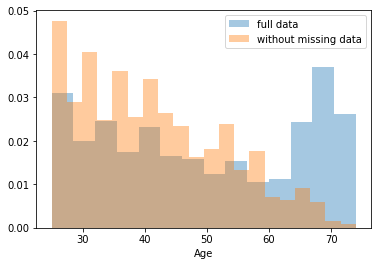

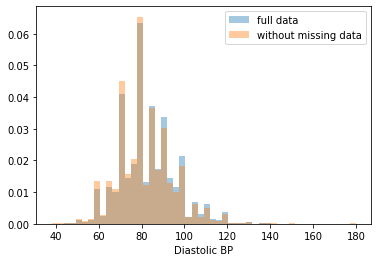

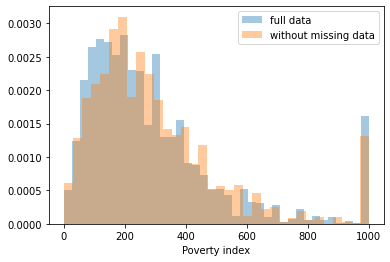

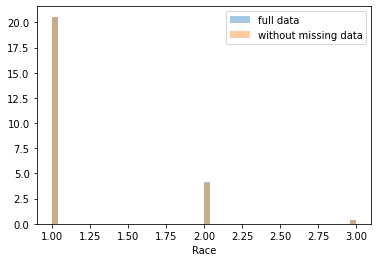

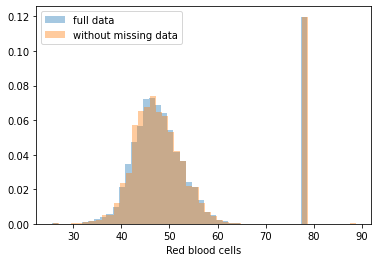

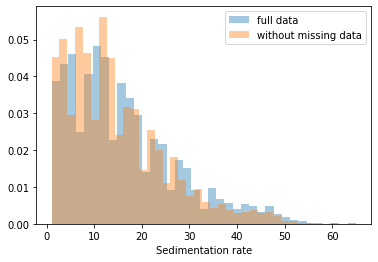

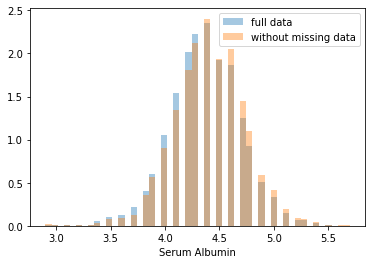

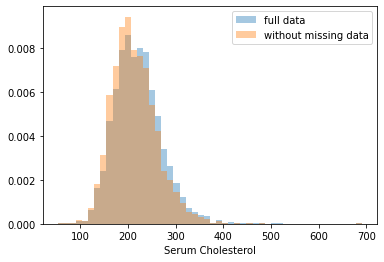

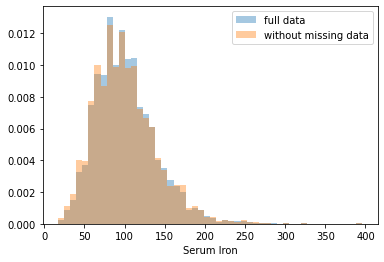

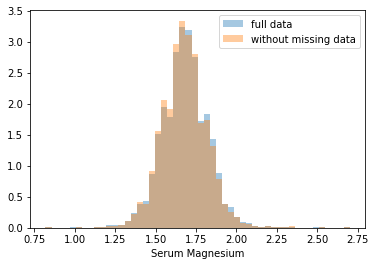

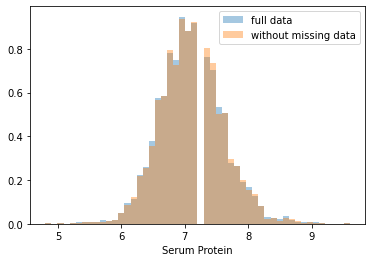

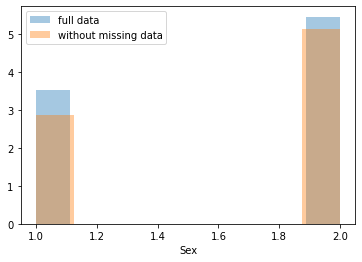

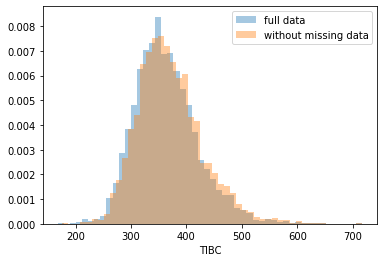

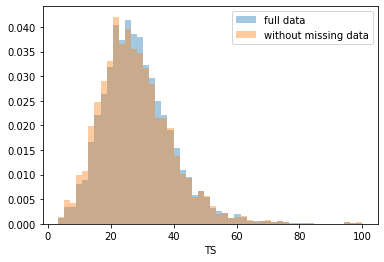

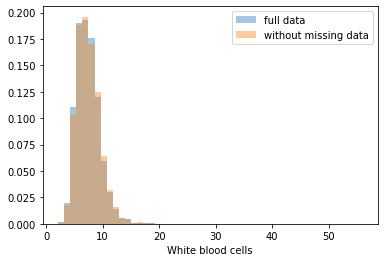

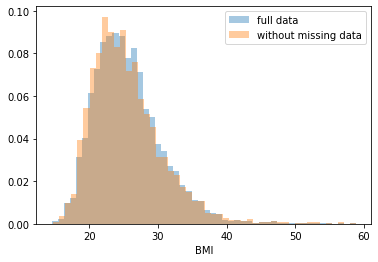

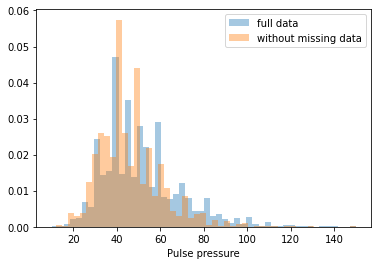

In [47]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [col for col in X_train.columns if col not in ['Systolic BP']]

for col in columns_except_Systolic_BP:
    sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label='full data')
    sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label='without missing data')
    plt.legend()

    plt.show()

In [0]:
def bad_subset(forest, X_test, y_test):
    # define mask to select large subset with poor performance
    # currently mask defines the entire set

    mask = X_test.Age < 40

    X_subgroup = X_test[mask]
    y_subgroup = y_test[mask]
    subgroup_size = len(X_subgroup)

    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = cindex(y_subgroup.values, y_subgroup_preds)

    return performance, subgroup_size

In [49]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)

print("Subgroup size should greater than 250, performance should be less than 0.69")
print(f"Subgroup size: {subgroup_size}, C-Index: {performance}")

Subgroup size should greater than 250, performance should be less than 0.69
Subgroup size: 586, C-Index: 0.6274714828897339


In [0]:
# Impute values using the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)

X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [0]:
# Define ranges for the random forest hyperparameter search
hyperparams = {

    # how many trees should be in the forest (int)
    'n_estimators': [100, 150, 200],

    # the maximum depth of trees in the forest (int)
    'max_depth': [3, 4, 5],

    # the minimum number of samples in a leaf as a fraction
    # of the total number of samples in the training set
    # Can be int (in which case that is the minimum number)
    # or float (in which case the minimum is that fraction of the
    # number of training set samples)
    'min_samples_leaf': [3, 4],
}

In [53]:
rf = RandomForestClassifier

rf_mean_imputed, best_hyperparams_mean_imputed = holdout_grid_search(rf, X_train_mean_imputed, y_train,
                                                                     X_val_mean_imputed, y_val,
                                                                     hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_mean_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/18] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.7355381411780544

[2/18] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.7351896364911549

[3/18] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.7433713540004212

[4/18] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.7431542171238483

[5/18] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 3}
Val C-Index: 0.7494088448535303

[6/18] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 4}
Val C-Index: 0.7476066087779754

[7/18] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.737671510990383

[8/18] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.7375510000238851

[9/18] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.745231131348268

[10/18] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.745029194

In [54]:
# Impute using regression on other covariates
imputer = IterativeImputer(random_state=0, sample_posterior=False, max_iter=1, min_value=0)
imputer.fit(X_train)

X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

[IterativeImputer] Early stopping criterion not reached.


In [0]:
# Define ranges for the random forest hyperparameter search
hyperparams = {

    # how many trees should be in the forest (int)
    'n_estimators': [100, 150, 200],

    # the maximum depth of trees in the forest (int)
    'max_depth': [3, 4, 5],

    # the minimum number of samples in a leaf as a fraction
    # of the total number of samples in the training set
    # Can be int (in which case that is the minimum number)
    # or float (in which case the minimum is that fraction of the
    # number of training set samples)
    'min_samples_leaf': [3, 4],
}

In [56]:
rf = RandomForestClassifier

rf_imputed, best_hyperparams_imputed = holdout_grid_search(rf, X_train_imputed, y_train,
                                                                     X_val_imputed, y_val,
                                                                     hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_imputed.predict_proba(X_train_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_imputed.predict_proba(X_val_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/18] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.7329770117188772

[2/18] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.7325264526999885

[3/18] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.7406224011430085

[4/18] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.7401512141208454

[5/18] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 3}
Val C-Index: 0.7439022536636419

[6/18] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 4}
Val C-Index: 0.7433290123094896

[7/18] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.7338140743780657

[8/18] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.7336707640395276

[9/18] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.7409926195175653

[10/18] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.7403889

In [57]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print(f"C-Index (no imputation): {performance}")

performance, subgroup_size = bad_subset(rf_mean_imputed, X_test, y_test)
print(f"C-Index (mean imputation): {performance}")

performance, subgroup_size = bad_subset(rf_imputed, X_test, y_test)
print(f"C-Index (multivariate feature imputation): {performance}")

C-Index (no imputation): 0.6274714828897339
C-Index (mean imputation): 0.5974334600760456
C-Index (multivariate feature imputation): 0.5903992395437262


In [59]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.619022
1017,65.0,98.0,16.0,1.0,49.4,30.0,3.4,124.0,129.0,1.59,7.7,1.0,184.0,293.0,44.0,5.9,30.858853,86.0,0.545443
2050,66.0,100.0,69.0,2.0,42.9,47.0,3.8,233.0,170.0,1.42,8.6,1.0,180.0,411.0,41.4,7.2,22.129498,80.0,0.527768
6337,69.0,80.0,233.0,1.0,77.7,48.0,4.2,159.0,87.0,1.81,6.9,1.0,146.0,291.0,29.9,15.2,17.931276,66.0,0.526019
2608,71.0,80.0,104.0,1.0,43.8,23.0,4.0,201.0,119.0,1.60,7.0,1.0,166.0,311.0,38.3,6.3,17.760766,86.0,0.525624


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


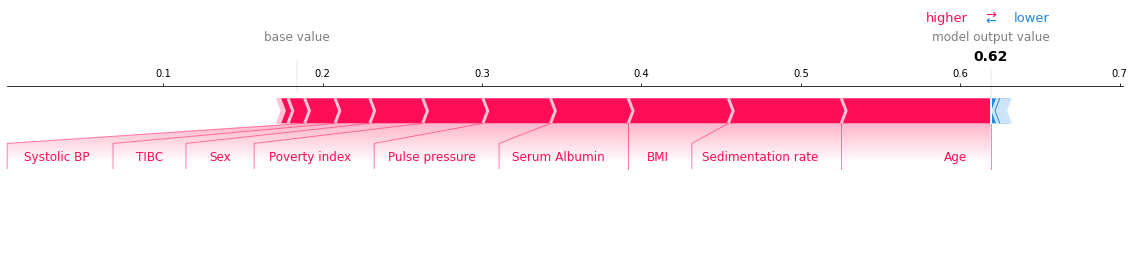

In [61]:
explainer = shap.TreeExplainer(rf_imputed)
i = 0

shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

In [63]:
shap_values = shap.TreeExplainer(rf_imputed).shap_values(X_test)[1]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


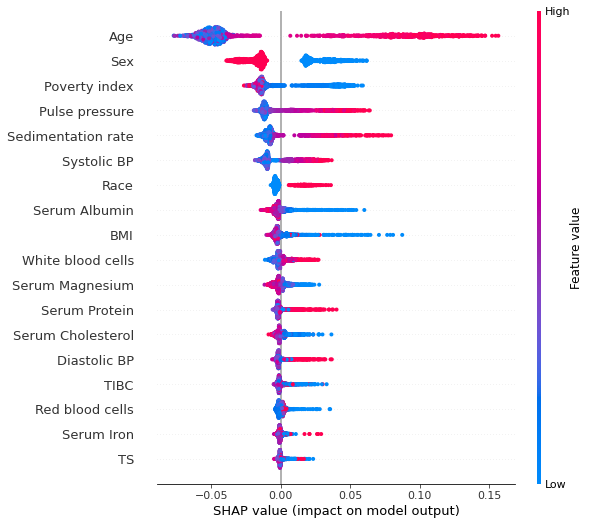

In [64]:
shap.summary_plot(shap_values, X_test)

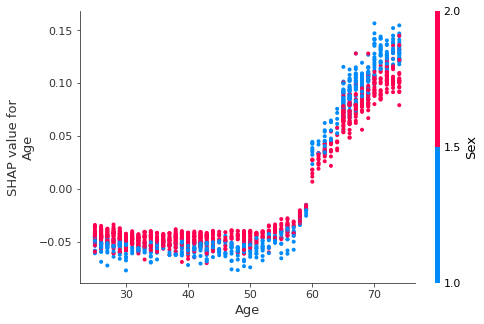

In [65]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

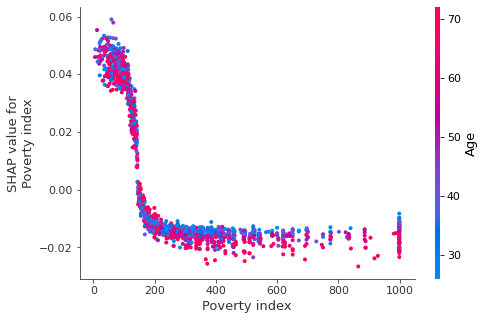

In [66]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')